In [1]:
from saris.utils import utils
import os
from typing import List, Tuple
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"  # to avoid memory fragmentation
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import tensorflow as tf
policy = tf.keras.mixed_precision.Policy("mixed_bfloat16")
tf.keras.mixed_precision.set_global_policy(policy)
tf.config.experimental.set_memory_growth(
    tf.config.experimental.list_physical_devices("GPU")[0], True
)
tf.random.set_seed(0)
from sionna.channel import (
    cir_to_ofdm_channel,
    subcarrier_frequencies,
    time_lag_discrete_time_channel,
    cir_to_time_channel,
    time_to_ofdm_channel,
)
from saris import sigmap
import math
import numpy as np

E0000 00:00:1735225194.418864   35095 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735225194.423757   35095 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

## One Flat Reflector

In [3]:
sionna_config_file = '/home/hieule/research/saris/configs/sionna_L_multi_users.yaml'
sionna_config = utils.load_config(sionna_config_file)
compute_scene_path = "/home/hieule/research/saris/default_scenes/blender/default/ceiling_idx/hallway.xml"
viz_scene_path = "/home/hieule/research/saris/default_scenes/blender/default/idx/hallway.xml"

I0000 00:00:1735225197.458326   35095 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1735225197.458528   35095 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4749 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


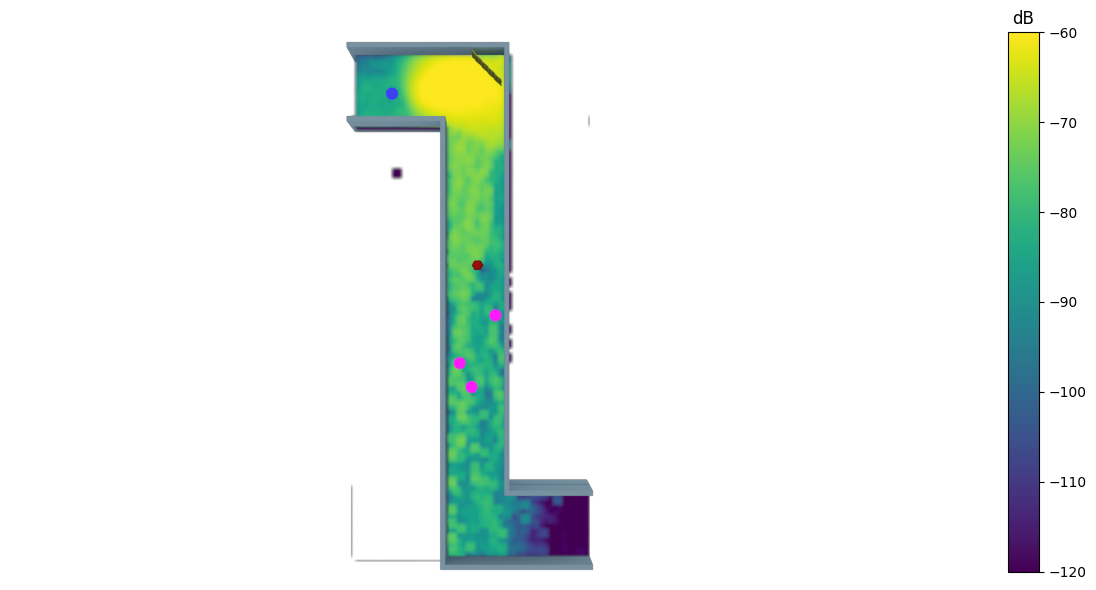

In [4]:
def compute_rot_angle(pt1: list, pt2: list) -> Tuple[float, float, float]:
    """Compute the rotation angles for vector pt1 to pt2."""
    x = pt2[0] - pt1[0]
    y = pt2[1] - pt1[1]
    z = pt2[2] - pt1[2]

    return cartesian2spherical(x, y, z)


def cartesian2spherical(x: float, y: float, z: float) -> Tuple[float, float, float]:
    # theta: zenith angle (0, pi), phi: azimuthal angle (0, 2pi)
    r = math.sqrt(x**2 + y**2 + z**2)
    theta = math.acos(z / r)
    phi = math.atan2(y, x)
    return r, theta, phi


def spherical2cartesian(r: float, theta: float, phi: float) -> Tuple[float, float, float]:
    # theta: zenith angle (0, pi), phi: azimuthal angle (0, 2pi)
    x = r * math.sin(theta) * math.cos(phi)
    y = r * math.sin(theta) * math.sin(phi)
    z = r * math.cos(theta)
    return x, y, z

ris_pos = sionna_config['ris_positions'][0]
tx_pos = sionna_config['tx_positions'][0]

r, theta, phi = compute_rot_angle(tx_pos, ris_pos)

sionna_config['tx_orientations'] = [[phi, theta - math.pi/2, 0.0]]
sig_cmap = sigmap.engine.SignalCoverageMap(
    sionna_config, compute_scene_path, viz_scene_path
)
coverage_map = sig_cmap.compute_cmap()
scene = sig_cmap.render(coverage_map)


In [5]:
sig_cmap.render_to_file(coverage_map, filename="one_flat_reflecor.png")

In [5]:
scene.preview(show_orientations=True, resolution=(1280, 720))

Renderer(camera=PerspectiveCamera(aspect=1.7777777777777777, children=(DirectionalLight(intensity=0.25, positi…

In [ ]:
bandwidth = 100e6
(l_min, l_max) = time_lag_discrete_time_channel(
            bandwidth, 10e-9
        )

paths = sig_cmap.compute_paths()
cir = paths.cir()
# a: [batch_size, num_rx, num_rx_ant, num_tx, num_tx_ant, max_num_paths, num_time_steps], tf.complex
a, tau = cir
# [batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, l_max - l_min + 1], tf.complex
channels: tf.Tensor = cir_to_time_channel(bandwidth, a, tau, l_min, l_max)
large_scale = tf.reduce_mean(
    tf.reduce_sum(tf.square(tf.abs(channels)), axis=6, keepdims=True),
    axis=(2, 4, 5),
    keepdims=True,
)
path_gains = tf.squeeze(large_scale, axis=(0, 2, 3, 4, 5, 6)).numpy()

In [7]:
path_gain_dBs = utils.linear2dB(path_gains)
path_gain_dBs

array([-80.63668, -93.44491, -87.61919], dtype=float32)

## No Reflector

In [6]:
sionna_config_file = '/home/hieule/research/saris/configs/sionna_L_multi_users.yaml'
sionna_config = utils.load_config(sionna_config_file)
compute_scene_path = "/home/hieule/research/saris/default_scenes/blender/noreflector/ceiling_idx/hallway.xml"
viz_scene_path = "/home/hieule/research/saris/default_scenes/blender/noreflector/idx/hallway.xml"

ris_pos: [2.09223, -3.88804, 2.06059]
tx_pos: [1.0, 0.0, 2.5]


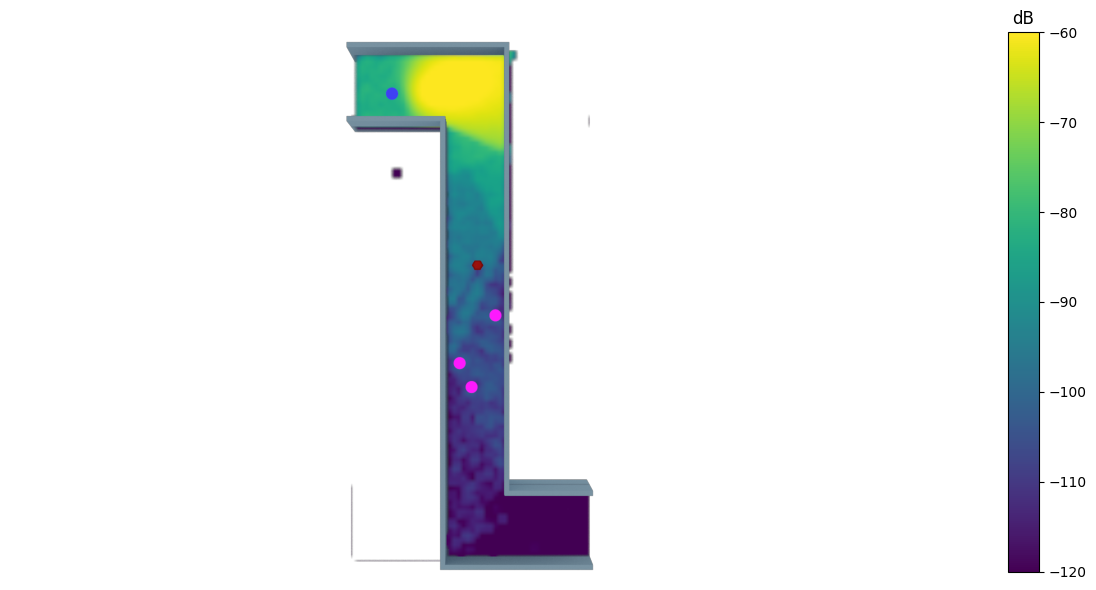

In [7]:
def compute_rot_angle(pt1: list, pt2: list) -> Tuple[float, float, float]:
    """Compute the rotation angles for vector pt1 to pt2."""
    x = pt2[0] - pt1[0]
    y = pt2[1] - pt1[1]
    z = pt2[2] - pt1[2]

    return cartesian2spherical(x, y, z)


def cartesian2spherical(x: float, y: float, z: float) -> Tuple[float, float, float]:
    # theta: zenith angle (0, pi), phi: azimuthal angle (0, 2pi)
    r = math.sqrt(x**2 + y**2 + z**2)
    theta = math.acos(z / r)
    phi = math.atan2(y, x)
    return r, theta, phi


def spherical2cartesian(r: float, theta: float, phi: float) -> Tuple[float, float, float]:
    # theta: zenith angle (0, pi), phi: azimuthal angle (0, 2pi)
    x = r * math.sin(theta) * math.cos(phi)
    y = r * math.sin(theta) * math.sin(phi)
    z = r * math.cos(theta)
    return x, y, z



ris_pos = sionna_config['ris_positions'][0]
tx_pos = sionna_config['tx_positions'][0]

print(f"ris_pos: {ris_pos}")
print(f"tx_pos: {tx_pos}")

r, theta, phi = compute_rot_angle(tx_pos, ris_pos)


sionna_config['tx_orientations'] = [[phi, theta - math.pi/2, 0.0]]
sig_cmap = sigmap.engine.SignalCoverageMap(
    sionna_config, compute_scene_path, viz_scene_path
)
coverage_map = sig_cmap.compute_cmap()
scene = sig_cmap.render(coverage_map)


In [8]:
sig_cmap.render_to_file(coverage_map, filename="no_reflecor.png")

In [ ]:
bandwidth = 100e6
(l_min, l_max) = time_lag_discrete_time_channel(
            bandwidth, 10e-9
        )

paths = sig_cmap.compute_paths()
cir = paths.cir()
# a: [batch_size, num_rx, num_rx_ant, num_tx, num_tx_ant, max_num_paths, num_time_steps], tf.complex
a, tau = cir
# [batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, l_max - l_min + 1], tf.complex
channels: tf.Tensor = cir_to_time_channel(bandwidth, a, tau, l_min, l_max)
large_scale = tf.reduce_mean(
    tf.reduce_sum(tf.square(tf.abs(channels)), axis=6, keepdims=True),
    axis=(2, 4, 5),
    keepdims=True,
)
path_gains = tf.squeeze(large_scale, axis=(0, 2, 3, 4, 5, 6)).numpy()

In [11]:
path_gain_dBs = utils.linear2dB(path_gains)
path_gain_dBs

array([-106.81305 , -103.116165, -105.44999 ], dtype=float32)

## Reflector

In [3]:
sionna_config_file = '/home/hieule/research/saris/configs/sionna_L_multi_users.yaml'
sionna_config = utils.load_config(sionna_config_file)
compute_scene_path = "/home/hieule/research/saris/local_assets/blender/hallway_L_0/ceiling_idx/hallway.xml"
viz_scene_path = "/home/hieule/research/saris/local_assets/blender/hallway_L_0/idx/hallway.xml"

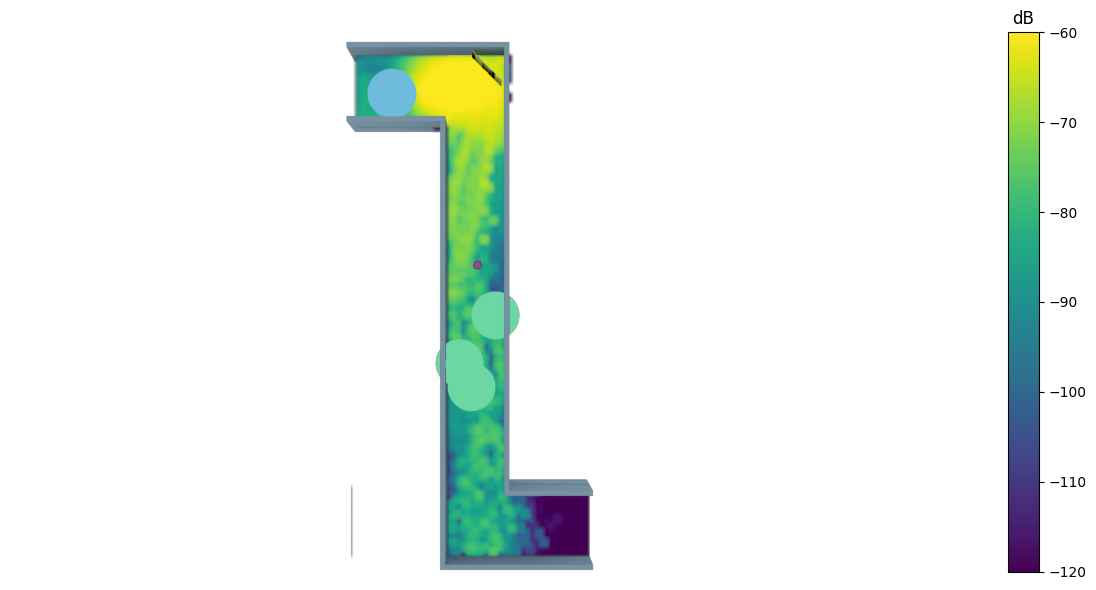

In [4]:
def compute_rot_angle(pt1: list, pt2: list) -> Tuple[float, float, float]:
    """Compute the rotation angles for vector pt1 to pt2."""
    x = pt2[0] - pt1[0]
    y = pt2[1] - pt1[1]
    z = pt2[2] - pt1[2]

    return cartesian2spherical(x, y, z)


def cartesian2spherical(x: float, y: float, z: float) -> Tuple[float, float, float]:
    # theta: zenith angle (0, pi), phi: azimuthal angle (0, 2pi)
    r = math.sqrt(x**2 + y**2 + z**2)
    theta = math.acos(z / r)
    phi = math.atan2(y, x)
    return r, theta, phi


def spherical2cartesian(r: float, theta: float, phi: float) -> Tuple[float, float, float]:
    # theta: zenith angle (0, pi), phi: azimuthal angle (0, 2pi)
    x = r * math.sin(theta) * math.cos(phi)
    y = r * math.sin(theta) * math.sin(phi)
    z = r * math.cos(theta)
    return x, y, z

ris_pos = sionna_config['ris_positions'][0]
tx_pos = sionna_config['tx_positions'][0]

r, theta, phi = compute_rot_angle(tx_pos, ris_pos)

sionna_config['tx_orientations'] = [[phi, theta - math.pi/2, 0.0]]
sig_cmap = sigmap.engine.SignalCoverageMap(
    sionna_config, compute_scene_path, viz_scene_path
)
coverage_map = sig_cmap.compute_cmap()
scene = sig_cmap.render(coverage_map)

In [5]:
scene.preview(show_orientations=True, resolution=(1280, 720))

Renderer(camera=PerspectiveCamera(aspect=1.7777777777777777, children=(DirectionalLight(intensity=0.25, positi…

In [9]:
coverage_map.path_gain.shape

TensorShape([1, 51, 107])

In [16]:
tmp = []
for pos in coverage_map.rx_pos:
    path_gain = coverage_map.path_gain[:, pos[1], pos[0]]
    tmp.append(path_gain)

In [17]:
tmp = np.asarray(tmp)
print(f"tmp shape: {tmp.shape}")
print(f"tmp: \t{utils.linear2dB(tmp)}")

tmp shape: (3, 1)
tmp: 	[[ -83.32294]
 [-105.13664]
 [-103.75015]]


In [18]:
path_gains = sig_cmap.get_path_gain(coverage_map)
path_gains
print(f"cpath_gain_dB: \t{utils.linear2dB(path_gains)}")

cpath_gain_dB: 	[ -83.32293042 -105.13664068 -103.75015014]


In [ ]:
a = coverage_map.cell_to_tx("rss")

<tf.Tensor: shape=(51, 107), dtype=int64, numpy=
array([[-1,  0,  0, ..., -1, -1, -1],
       [-1,  0,  0, ..., -1, -1, -1],
       [-1,  0,  0, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ...,  0,  0, -1],
       [-1, -1, -1, ...,  0,  0, -1],
       [-1, -1, -1, ..., -1, -1, -1]])>

In [ ]:
bandwidth = 100e6
(l_min, l_max) = time_lag_discrete_time_channel(
            bandwidth, 10e-9
        )

paths = sig_cmap.compute_paths()
cir = paths.cir()
# a: [batch_size, num_rx, num_rx_ant, num_tx, num_tx_ant, max_num_paths, num_time_steps], tf.complex
a, tau = cir
# [batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, l_max - l_min + 1], tf.complex
channels: tf.Tensor = cir_to_time_channel(bandwidth, a, tau, l_min, l_max)
large_scale = tf.reduce_mean(
    tf.reduce_sum(tf.square(tf.abs(channels)), axis=6, keepdims=True),
    axis=(2, 4, 5),
    keepdims=True,
)
path_gains = tf.squeeze(large_scale, axis=(0, 2, 3, 4, 5, 6)).numpy()

In [ ]:
path_gain_dBs = utils.linear2dB(path_gains)
path_gain_dBs

array([-80.63668, -93.44491, -87.61919], dtype=float32)